The debiasing function used is implemented in the `RejectOptionClassification` class.

    * Statistical parity difference on the predictions of the classifier
    * Average odds difference for the classifier
    * Equal opportunity difference for the classifier

In [1]:
%pip install mlxtend pyECLAT efficient-apriori plotly matplotlib inline seaborn aif360
# Load all necessary packages
import sys
sys.path.append("../")
from collections import OrderedDict
import numpy as np
import pandas as pd
import seaborn as sns

from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import association_rules, fpgrowth, apriori
from mlxtend.preprocessing import TransactionEncoder


Note: you may need to restart the kernel to use updated packages.


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Functions

In [2]:
# https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall

def compute_cl_metrics(dataset_true, dataset_pred,
                    disp = True):
    metrics = OrderedDict()
    metrics["Accuracy"] = accuracy_score(dataset_true.labels, dataset_pred.labels)
    metrics["Recall"] = recall_score(dataset_true.labels, dataset_pred.labels)
    metrics["Precision"] = precision_score(dataset_true.labels, dataset_pred.labels)
    metrics["Balanced accuracy"] = balanced_accuracy_score(dataset_true.labels, dataset_pred.labels)    
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [3]:
def compute_fn_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    # metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

In [4]:
def plot_metrics(metrics_bef, metrics_aft): 
    df_metrics = pd.DataFrame({
        'Metric': list(metrics_bef.keys()),
        'Before': list(metrics_bef.values()),
        'After': list(metrics_aft.values())
    })

    df_metrics_melted = df_metrics.melt(id_vars='Metric', var_name='Stage', value_name='Value')
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_metrics_melted, x='Stage', y='Value', hue='Metric', marker='o')
    # print a line at y = 0 in red
    plt.axhline(1, color='red', linestyle='--')


    plt.ylabel('Metric Value')
    plt.title('Comparison of Metrics Before and After Applying ROC')
    plt.legend(title='Metric')
    plt.grid(True)
    plt.show()

In [5]:
def plot_fn_metrics(metrics_bef, metrics_aft): 
    df_metrics = pd.DataFrame({
        'Metric': list(metrics_bef.keys()),
        'Before': list(metrics_bef.values()),
        'After': list(metrics_aft.values())
    })

    df_metrics_melted = df_metrics.melt(id_vars='Metric', var_name='Stage', value_name='Value')
    
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df_metrics_melted, x='Stage', y='Value', hue='Metric', marker='o')
    # print a line at y = 0 in red
    plt.axhline(0, color='red', linestyle='--')


    plt.ylabel('Metric Value')
    plt.title('Comparison of Metrics Before and After Applying ROC')
    plt.legend(title='Metric')
    plt.grid(True)
    plt.show()

In [6]:
def conf_matrix(dataset_true, dataset_pred):
    cm =confusion_matrix(dataset_true.labels, dataset_pred.labels)
    plt.figure(figsize=(3, 3))
    
    ConfusionMatrixDisplay(cm).plot()
    return cm

In [7]:
def above_50k_graph(dataset):
    df_test = dataset.convert_to_dataframe()[0]
    df_above_50k = df_test[df_test['income'] == 1]
    df_above_50k

    # Count the number of male and female workers with income greater than 50K
    gender_counts = df_above_50k['sex'].value_counts()

    females_above_50k_count = gender_counts.get(0, 0) 
    total_count_above_50k = gender_counts.sum()
    print(f"Percentage of females earning over 50K: {females_above_50k_count/total_count_above_50k*100:.2f}%")
    print(f"Number of male workers earning over 50K: { gender_counts.get(1, 0)}")
    print(f"Total number of workers earning over 50K: {total_count_above_50k}")


    # Plotting the graph, the X axis gender should only contain 0 for female, 1 for male
    plt.figure(figsize=(5, 5))
    plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'moccasin'])
    plt.xlabel('Gender')
    plt.xticks([0, 1], labels=['Female', 'Male'])
    plt.ylabel('Number of Workers')
    plt.title('Number of Male and Female Workers with Salary > 50K')
    plt.show()

In [8]:
def above_50k_graph_df(df):
    df_above_50k = df[df['income'] == 1]

    # Count the number of male and female workers with income greater than 50K
    gender_counts = df_above_50k['sex'].value_counts()

    females_above_50k_count = gender_counts.get(0, 0) 
    total_count_above_50k = gender_counts.sum()
    print(f"Percentage of females earning over 50K: {females_above_50k_count/total_count_above_50k*100:.2f}%")
    print(f"Number of male workers earning over 50K: { gender_counts.get(1, 0)}")
    print(f"Total number of workers earning over 50K: {total_count_above_50k}")

    # Plotting the graph, the X axis gender should only contain 0 for female, 1 for male
    plt.figure(figsize=(5, 5))
    plt.bar(gender_counts.index, gender_counts.values, color=['lightblue', 'moccasin'])
    plt.xlabel('Gender')
    plt.xticks([0, 1], labels=['Female', 'Male'])
    plt.ylabel('Number of Workers')
    plt.title('Number of Male and Female Workers with Salary > 50K')
    plt.show()

In [9]:
def group_edu(x):
    if x <= 5:
        return '<6'
    elif x >= 13:
        return '>12'
    else:
        return x

### Load dataset and specify options

In [10]:
# define the ML model
# Decision Tree, Logistic Regression
model = "Decision Tree"

# TODO: privileged groups should be defined based on the dataset!
# privileged_groups = [{'sex': 1}]
# unprivileged_groups = [{'sex': 0}]


target_variable = 'income'
sensible_attribute = 'sex'

# Associaction rules parameters
user_min_support = 0.2
user_min_confidence = 0.8
        
# The debiasing function RejectOptionClassification accepts the following metrics:
    # Statistical parity difference on the predictions of the classifier
    # Average odds difference for the classifier
    # Equal opportunity difference for the classifier
metric_name = "Statistical parity difference"
        
#random seed for calibrated equal odds prediction
np.random.seed(1)

# Verify metric name
allowed_metrics = ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]
if metric_name not in allowed_metrics:
    raise ValueError("Metric name should be one of allowed metrics")

## Load and clean csv file

In [11]:
# https://www.kaggle.com/datasets/uciml/adult-census-income/data
dataset_orig = pd.read_csv('dataset/adult.csv', header = 0)
print('shape before drop:',dataset_orig.shape)
dataset_orig.replace('?', np.nan, inplace=True)
dataset_orig.dropna(inplace=True)
# to_drop = ["workclass", "fnlwgt", "education", "capital-gain", "capital-loss", "hours-per-week"]

to_drop = ["fnlwgt", "education", "relationship", "workclass", "occupation"]
dataset_orig_clean = dataset_orig.dropna()
dataset_orig_clean.drop(to_drop, axis=1, inplace=True)

print('shape after drop:',dataset_orig.shape)


shape before drop: (32561, 15)
shape after drop: (30162, 15)


In [12]:
dataset_orig

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [13]:
# Categorical features are converted to numerical
dataset_orig_clean.loc[:, 'income'] = dataset_orig_clean['income'].map({
    '<=50K': 0,
    '>50K': 1
})
dataset_orig_clean['income'] = dataset_orig_clean['income'].astype(int)


dataset_orig_clean.loc[:, 'sex'] = dataset_orig_clean['sex'].map({
    'Female': 0,
    'Male': 1
})
dataset_orig_clean['sex'] = dataset_orig_clean['sex'].astype(int)

# 1 if married, 0 otherwise
dataset_orig_clean['marital.status'] = dataset_orig_clean['marital.status'].map({
    'Never-married': 0,
    'Divorced': 0,
    'Separated': 0,
    'Widowed': 0,
    'Married-civ-spouse': 1,
    'Married-spouse-absent': 1,
    'Married-AF-spouse': 1
})
dataset_orig_clean['marital.status'] = dataset_orig_clean['marital.status'].astype(int)


dataset_orig_clean['race'] = dataset_orig_clean['race'].apply(lambda x: 1 if x == 'White' else 0)
dataset_orig_clean['race'] = dataset_orig_clean['race'].astype(int)

# United-States is 0 all the other countries are 1
dataset_orig_clean['native.country'] = dataset_orig_clean['native.country'].apply(lambda x: 1 if x == 'United-States' else 0)
dataset_orig_clean['native.country'] = dataset_orig_clean['native.country'].astype(int)




In [14]:
dataset_orig_clean

,age,education.num,marital.status,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,82,9,0,1,0,0,4356,18,1,0
3,54,4,0,1,0,0,3900,40,1,0
4,41,10,0,1,0,0,3900,40,1,0
5,34,9,0,1,0,0,3770,45,1,0
6,38,6,0,1,1,0,3770,40,1,0
...,...,...,...,...,...,...,...,...,...,...
32556,22,10,0,1,1,0,0,40,1,0
32557,27,12,1,1,0,0,0,38,1,0
32558,40,9,1,1,1,0,0,40,1,1
32559,58,9,0,1,0,0,0,40,1,0


### Dataset visual

income
0    22654
1     7508
Name: count, dtype: int64


<Figure size 5000x5000 with 0 Axes>

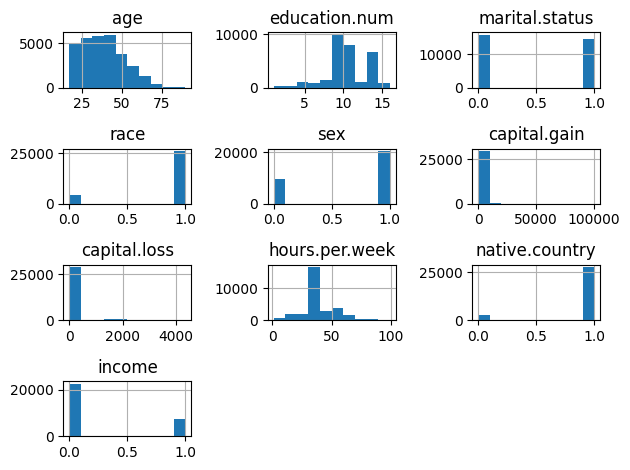

In [15]:
# what does the data look like now?
plt.figure(figsize=(50,50))

print(dataset_orig_clean['income'].value_counts())

# Plot the histogram of the dataset
dataset_orig_clean.hist()
plt.tight_layout()


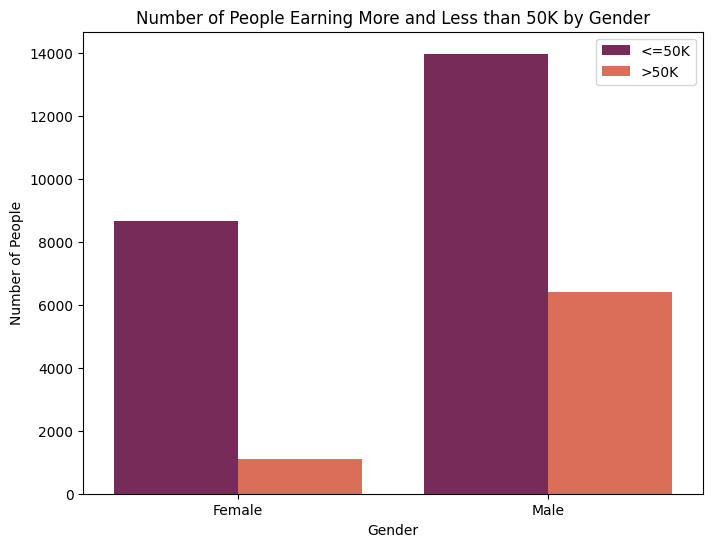

In [16]:
# Count the number of people earning more and less than 50K, divided by gender
income_gender_counts = dataset_orig_clean.groupby(['sex', 'income']).size().unstack()
# Plot the graph using seaborn
plt.figure(figsize=(8,6))
ax = sns.countplot(data=dataset_orig_clean, x='sex', hue='income', palette='rocket')
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.title('Number of People Earning More and Less than 50K by Gender')
plt.xticks([0, 1], labels=['Female', 'Male'], rotation=0)
plt.legend(['<=50K', '>50K'])
plt.show()

In [17]:
binary_dataset = BinaryLabelDataset(
    df=dataset_orig_clean.copy(),
    label_names=['income'],
    favorable_label=1,
    unfavorable_label=0,
    protected_attribute_names=[sensible_attribute])

### Split into train and test

In [18]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_test = binary_dataset.split([0.6], shuffle=True)

In [19]:
display(Markdown("#### Training & Test dimensions"))
print(dataset_orig_train.features.shape[0],",", dataset_orig_test.features.shape[0])

#### Training & Test dimensions

18097 , 12065


Percentage of females earning over 50K: 14.89%
Number of male workers earning over 50K: 3817
Total number of workers earning over 50K: 4485


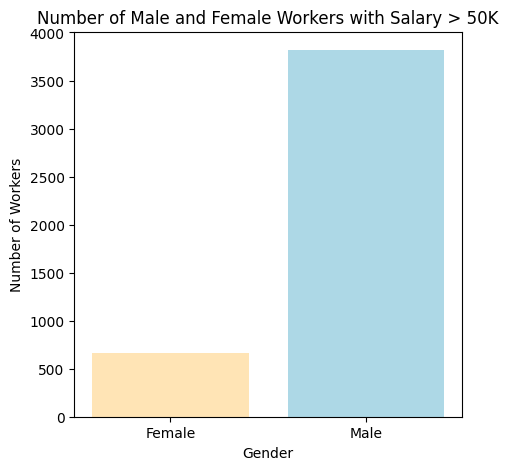

In [20]:
above_50k_graph(dataset_orig_train)

Percentage of females earning over 50K: 14.69%
Number of male workers earning over 50K: 2579
Total number of workers earning over 50K: 3023


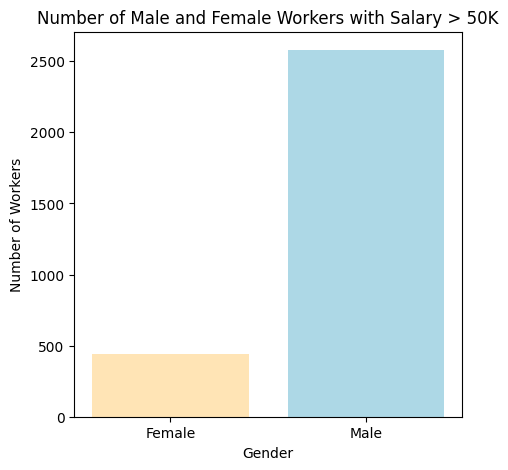

In [21]:
above_50k_graph(dataset_orig_test)

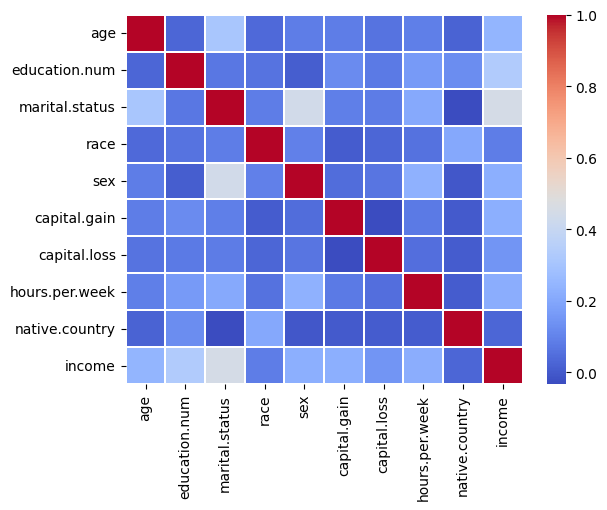

In [22]:
df_test = dataset_orig_test.convert_to_dataframe()[0]
g = sns.heatmap(df_test.corr(), annot=False, cmap="coolwarm", linewidths = 0.1)
plt.show()

#### Display properties of the training dataset

In [23]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(18097, 9)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['age', 'education.num', 'marital.status', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']


In [24]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Statistical Parity Difference or Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Statistical Parity Difference or Difference in mean outcomes between unprivileged and privileged groups = -0.196715


### Train classifier on original data

In [25]:
scale_orig = StandardScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

In [26]:
if model == "Decision Tree":
    model_instance = DecisionTreeClassifier(max_features=14,min_samples_leaf=100,random_state=10)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)
elif model == "Logistic Regression":
    model_instance = LogisticRegression(random_state=101)
    model_instance.fit(X_train, y_train)
    y_train_pred = model_instance.predict(X_train)



# positive class index
pos_ind = np.where(model_instance.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred


Percentage of females earning over 50K: 12.23%
Number of male workers earning over 50K: 2970
Total number of workers earning over 50K: 3384


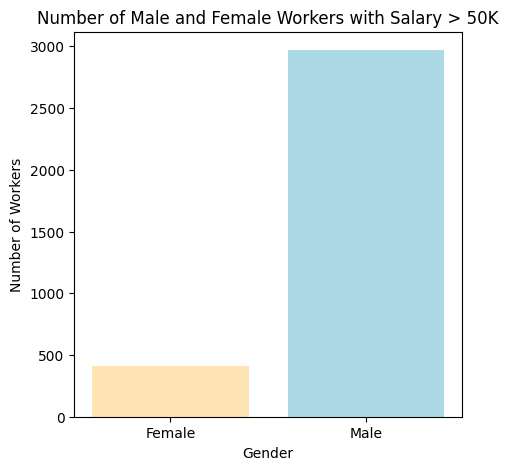

In [27]:
df_train_pred = dataset_orig_train_pred.copy(deepcopy=True)
df_train_pred.labels = df_train_pred.labels.reshape(-1, 1)
df_train_pred = df_train_pred.convert_to_dataframe()[0]


above_50k_graph_df(df_train_pred)


In [28]:
if model == "Decision Tree":
    print("Criterion:", model_instance.criterion)
    print("Depth:", model_instance.get_depth())
    print("Min samples per leaf:", model_instance.min_samples_leaf)
    print("Feature importances: ",list(zip(dataset_orig_train.feature_names, model_instance.feature_importances_)))


Criterion: gini
Depth: 14
Min samples per leaf: 100
Feature importances:  [('age', np.float64(0.06247953432952098)), ('education.num', np.float64(0.24967326706239226)), ('marital.status', np.float64(0.40485150316738316)), ('race', np.float64(0.001118880759900979)), ('sex', np.float64(0.004348194961055004)), ('capital.gain', np.float64(0.20663671927470073)), ('capital.loss', np.float64(0.034243412085327225)), ('hours.per.week', np.float64(0.036487352962521535)), ('native.country', np.float64(0.00016113539719797473))]


In [29]:
accuracy_score(dataset_orig_train.labels, dataset_orig_train_pred.labels)

0.8484279162292092

### Obtain scores for test set and find the optimal parameters from the test set

In [30]:
dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = model_instance.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

#### Best threshold for classification only (no fairness)

if one label is more common than the other label, then the dataset is imbalanced -> balanced accuracy

0.5*(classified_metric_orig_test.true_positive_rate() + classified_metric_orig_test.true_negative_rate())

In [31]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_test_pred.scores > class_thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    classified_metric_orig_test = ClassificationMetric(dataset_orig_test,
                                             dataset_orig_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = balanced_accuracy_score(dataset_orig_test.labels, dataset_orig_test_pred.labels)

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))

print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.8152
Optimal classification threshold (no fairness constraints) = 0.2179


### Post-procesing technique

#### Estimate optimal parameters for the ROC method

In [32]:
# Upper and lower bound on the fairness metric used
metric_ub = 0.05
metric_lb = -0.05

In [33]:
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.1, high_class_thresh=0.9,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_test, dataset_orig_test_pred)

In [34]:
print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.2374
Optimal ROC margin = 0.1647


#### Predictions from Test Set

In [35]:
# Metrics for the test set
# if the probability of the positive class is greater than or equal to best_class_thresh, the sample will be classified as positive
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_cl_test_bef = compute_cl_metrics(dataset_orig_test, dataset_orig_test_pred)
metric_fn_test_bef = compute_fn_metrics(dataset_orig_test, dataset_orig_test_pred, unprivileged_groups, privileged_groups)

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Accuracy = 0.7927
Recall = 0.8604
Precision = 0.5558
Balanced accuracy = 0.8152
Statistical parity difference = -0.3643
Average odds difference = -0.2302
Equal opportunity difference = -0.2060


<Figure size 300x300 with 0 Axes>

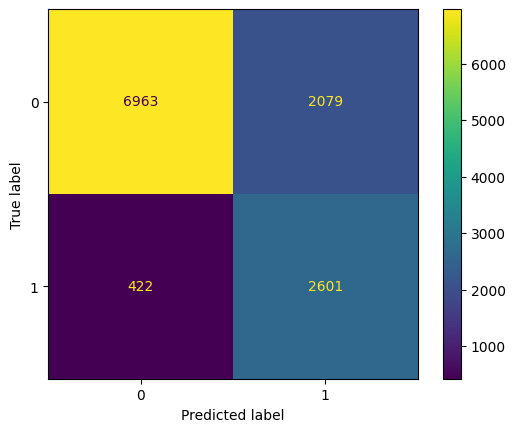

In [36]:
cm_test = conf_matrix(dataset_orig_test, dataset_orig_test_pred)

TP_discr = cm_test[1][1]
TN_discr = cm_test[0][0]
FN_discr = cm_test[1][0]
FP_discr = cm_test[0][1]

Percentage of females earning over 50K: 12.05%
Number of male workers earning over 50K: 4116
Total number of workers earning over 50K: 4680


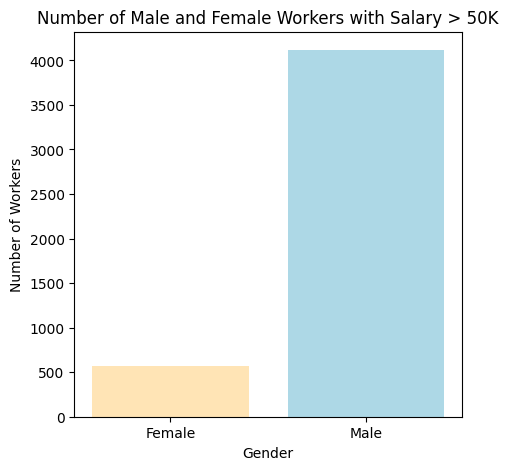

In [37]:
above_50k_graph(dataset_orig_test_pred)

#### ROC prediction

In [38]:
# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_cl_test_aft = compute_cl_metrics(dataset_orig_test, dataset_transf_test_pred)
metric_fn_test_aft = compute_fn_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)

#### Test set

##### Transformed predictions - With fairness constraints

Accuracy = 0.8068
Recall = 0.7218
Precision = 0.5942
Balanced accuracy = 0.7785
Statistical parity difference = -0.0485
Average odds difference = 0.1142
Equal opportunity difference = 0.1783


array([[7552, 1490],
       [ 841, 2182]])

<Figure size 300x300 with 0 Axes>

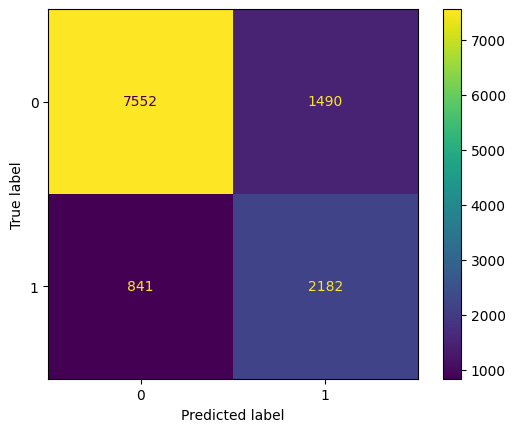

In [39]:
conf_matrix(dataset_orig_test, dataset_transf_test_pred)

Percentage of females earning over 50K: 29.22%
Number of male workers earning over 50K: 2599
Total number of workers earning over 50K: 3672


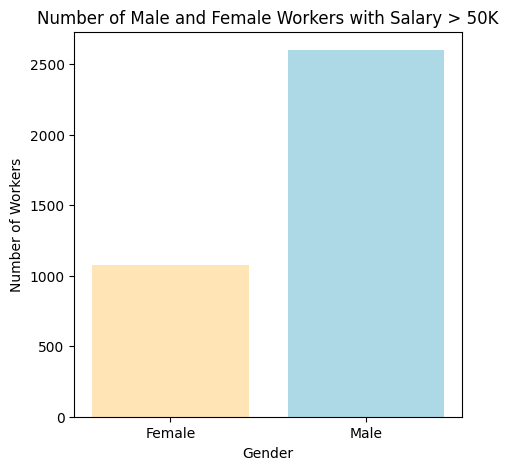

In [40]:
above_50k_graph(dataset_transf_test_pred)

In [41]:
# Count the number of people earning more and less than 50K, divided by gender for the original test dataset, predicted test dataset and predicted after pp
income_gender_counts_test = dataset_orig_test.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()
income_gender_counts_test_pred = dataset_orig_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()
income_gender_counts_transf_test_pred = dataset_transf_test_pred.convert_to_dataframe()[0].groupby(['sex', 'income']).size().unstack()

df_comparison = pd.DataFrame({
    'Male(<=50K)': [income_gender_counts_test.loc[1, 0], income_gender_counts_test_pred.loc[1, 0], income_gender_counts_transf_test_pred.loc[1,0]],
    'Male(>50K)': [income_gender_counts_test.loc[1, 1], income_gender_counts_test_pred.loc[1, 1], income_gender_counts_transf_test_pred.loc[1,1]],
    'Female(<=50K)': [income_gender_counts_test.loc[0, 0], income_gender_counts_test_pred.loc[0, 0], income_gender_counts_transf_test_pred.loc[0,0]],
    'Female(>50K)': [income_gender_counts_test.loc[0, 1], income_gender_counts_test_pred.loc[0, 1], income_gender_counts_transf_test_pred.loc[0,1]],
})

df_comparison


,Male(<=50K),Male(>50K),Female(<=50K),Female(>50K)
0,5537,2579,3505,444
1,4000,4116,3385,564
2,5517,2599,2876,1073


In [42]:
df_comparison_2 = pd.DataFrame({
    'Gender': ['Female', 'Male'],
    'Original <=50K': [income_gender_counts_test.loc[0, 0], income_gender_counts_test.loc[1, 0]],
    'Original >50K': [income_gender_counts_test.loc[0, 1], income_gender_counts_test.loc[1, 1]],
    'Pred bf pp <=50K': [income_gender_counts_test_pred.loc[0, 0], income_gender_counts_test_pred.loc[1, 0]],
    'Pred bf pp >50K': [income_gender_counts_test_pred.loc[0, 1], income_gender_counts_test_pred.loc[1, 1]],
    'Pred aft pp <=50K': [income_gender_counts_transf_test_pred.loc[0, 0], income_gender_counts_transf_test_pred.loc[1, 0]],
    'Pred aft pp >50K': [income_gender_counts_transf_test_pred.loc[0, 1], income_gender_counts_transf_test_pred.loc[1, 1]]
})
df_comparison_2

,Gender,Original <=50K,Original >50K,Pred bf pp <=50K,Pred bf pp >50K,Pred aft pp <=50K,Pred aft pp >50K
0,Female,3505,444,3385,564,2876,1073
1,Male,5537,2579,4000,4116,5517,2599


### Evaluation Metrics For Classification Model and Fairness

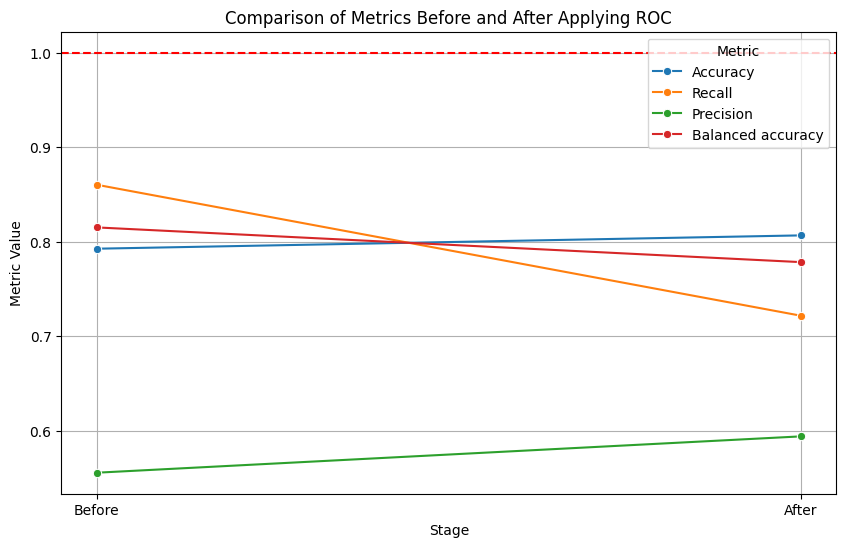

In [43]:
plot_metrics(metric_cl_test_bef, metric_cl_test_aft)

In [44]:
df_cl_metrics = pd.DataFrame({
    'Metric': list(metric_cl_test_bef.keys()),
    'Before': list(metric_cl_test_bef.values()),
    'After': list(metric_cl_test_aft.values())
})

# Calculate the percentage change
df_cl_metrics['Delta'] = (df_cl_metrics['After'] - df_cl_metrics['Before']).apply(lambda x: f"{x:.2f}")
df_cl_metrics

,Metric,Before,After,Delta
0,Accuracy,0.792706,0.806797,0.01
1,Recall,0.860404,0.721800,-0.14
2,Precision,0.555769,0.594227,0.04
3,Balanced accuracy,0.815238,0.778506,-0.04


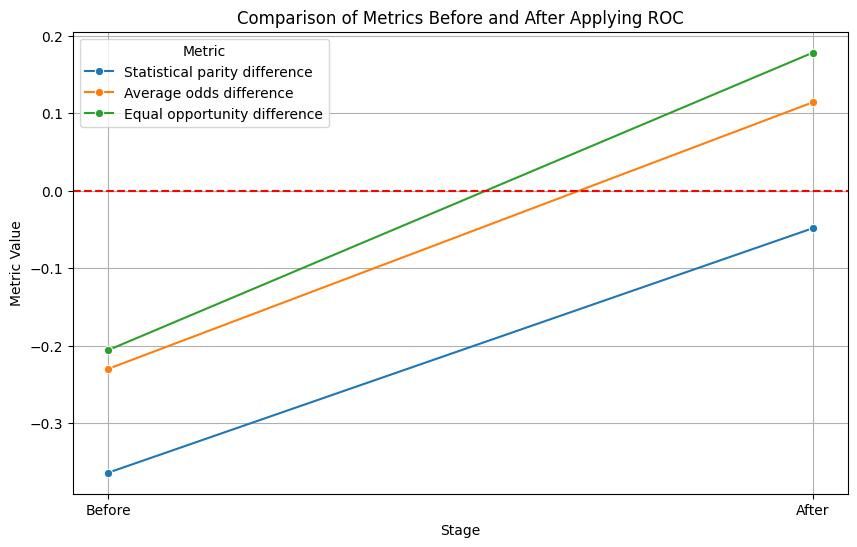

In [45]:
plot_fn_metrics(metric_fn_test_bef, metric_fn_test_aft)

In [46]:
df_metrics = pd.DataFrame({
    'Metric': list(metric_fn_test_bef.keys()),
    'Before': list(metric_fn_test_bef.values()),
    'After': list(metric_fn_test_aft.values())
})

# Calculate the percentage change
df_metrics['Delta'] = (df_metrics['After'] - df_metrics['Before']).apply(lambda x: f"+{x:.2f}")
df_metrics

,Metric,Before,After,Delta
0,Statistical parity difference,-0.364325,-0.048517,+0.32
1,Average odds difference,-0.230154,0.114152,+0.34
2,Equal opportunity difference,-0.205971,0.178255,+0.38


In [47]:
# Create a dataset that indicates how much metric_fn are before and after away from ideal value 0
df_fn_metrics = pd.DataFrame({
    'Metric': list(metric_fn_test_bef.keys()),
    'Before': list(metric_fn_test_bef.values()),
    'After': list(metric_fn_test_aft.values())
})

# Calculate how much metrics are away from the ideal value 0
df_fn_metrics['Before_dist_from_0'] = df_fn_metrics['Before'].abs().apply(lambda x: f"{x:.2f}")
df_fn_metrics['After_dist_from_0'] = df_fn_metrics['After'].abs().apply(lambda x: f"{x:.2f}")

df_fn_metrics['Delta'] = (df_fn_metrics['After'] - df_fn_metrics['Before']).apply(lambda x: f"+{x:.2f}")

# # Calculate the percentage of better/worse performance being near to 0
# df_fn_metrics['Percentage_Change'] = ((df_fn_metrics['Before_dist_from_0'] - df_fn_metrics['After_dist_from_0']) / df_fn_metrics['Before_dist_from_0']) * 100

df_fn_metrics

,Metric,Before,After,Before_dist_from_0,After_dist_from_0,Delta
0,Statistical parity difference,-0.364325,-0.048517,0.36,0.05,+0.32
1,Average odds difference,-0.230154,0.114152,0.23,0.11,+0.34
2,Equal opportunity difference,-0.205971,0.178255,0.21,0.18,+0.38


## Association rules

- Support: The proportion of transactions in the dataset where both antecedent and consequent are present.
    - Measures how frequently a rule is observed in the dataset.
- Confidence: The ratio of the number of times both antecedent and consequent occur together to the number of times the antecedent occurs.
    - Represents how often the rule is true.

**FP-GROWTH**

Compress a large database into a compact, Frequent-Pattern tree (FP-tree) structure.

Datasets are encoded using a compact structure, the FP-tree.

Frequent itemsets are extracted directly from the FP-tree.

***GOAL*** To avoid candidate generation (computationally expensive)

Main steps:

    1. Construct the frequent pattern tree
    2. For each frequent item: compute the projected FP-tree
    3. Mine conditional FP-trees and grow frequent patterns
    4. If the conditional FP-tree contains a single path: enumerate all the patterns


In [48]:
def prepare_dataset_asso_rules(dataset_to_prepare): 
    # Convert the dataset to a DataFrame
    pd_converted = dataset_to_prepare.convert_to_dataframe()[0]

    # Education number from 0 to 5 are put in '<6' and those above 13 into '>12'
    pd_converted['education.num'] = pd_converted['education.num'].apply(lambda x: group_edu(x))
    pd_converted['education.num'] = pd_converted['education.num'].astype(str)
    # Group age by decade
    pd_converted['Age (decade)'] = pd_converted['age'].apply(lambda x: x//10*10)
    pd_converted = pd_converted.drop(columns='age')
    # Group hours per week
    pd_converted['hours.per.week'] = pd_converted['hours.per.week'].apply(lambda x: '>40' if x > 40 else '<=40')

    # Capital gain is splitted into two columns capital.gain>0 and capital.gain=0
    pd_converted['capital.gain>0'] = pd_converted['capital.gain'].apply(lambda x: 1 if x > 0 else 0)
    pd_converted['capital.gain=0'] = pd_converted['capital.gain'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='capital.gain', inplace=True)

    # Capital loss is splitted into two columns capital.loss>0 and capital.loss=0
    pd_converted['capital.loss>0'] = pd_converted['capital.loss'].apply(lambda x: 1 if x > 0 else 0)
    pd_converted['capital.loss=0'] = pd_converted['capital.loss'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='capital.loss', inplace=True)


    pd_converted['male'] = pd_converted['sex'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['female'] = pd_converted['sex'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='sex', inplace=True) 

    # Process 'race' column
    pd_converted['white'] = pd_converted['race'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['n_white'] = pd_converted['race'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='race', inplace=True)

    # Process 'income' column
    pd_converted['>50K'] = pd_converted['income'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['<50K'] = pd_converted['income'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='income', inplace=True)

    # 1 if married, 0 otherwise
    pd_converted['married'] = pd_converted['marital.status'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['n_married'] = pd_converted['marital.status'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='marital.status', inplace=True)

    # United-States is 1 all the other countries are 0
    pd_converted['UnitedStates'] = pd_converted['native.country'].apply(lambda x: 1 if x == 1 else 0)
    pd_converted['n_UnitedStates'] = pd_converted['native.country'].apply(lambda x: 1 if x == 0 else 0)
    pd_converted.drop(columns='native.country', inplace=True)
    pd_converted.drop(columns=['capital.loss>0', 'capital.loss=0', 'capital.gain>0', 'capital.gain=0'], inplace=True)
    pd_converted.drop(columns=['hours.per.week'], inplace=True)

    return pd_converted

In [49]:
 
def compute_income_rules(dataset, min_support, min_confidence):
    data_asso_rules = prepare_dataset_asso_rules(dataset)
    data_asso_rules = pd.get_dummies(data_asso_rules,columns=['education.num','Age (decade)'],drop_first=False)

    # Create a binary representation of transactions
    df_transactions = data_asso_rules.map(lambda x: True if x > 0 else False)

    # Apply FP-growth algorithm to find frequent itemsets
    frequent_itemsets = fpgrowth(df_transactions, min_support=min_support, use_colnames=True)

    # Extract association rules with min confidence
    res = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

    res.to_csv('association_rules.csv')
    # Filter rules with consequents '<=50K' and '>50K'
    res_min50 = res[res['consequents'] == {'<50K'}]
    res_max50 = res[res['consequents'] == {'>50K'}]

    return res_min50, res_max50


In [50]:
 
def compute_df_transactions(dataset):
    data_asso_rules = prepare_dataset_asso_rules(dataset)
    data_asso_rules = pd.get_dummies(data_asso_rules,columns=['education.num','Age (decade)'],drop_first=False)

    # Create a binary representation of transactions
    df_transactions = data_asso_rules.map(lambda x: True if x > 0 else False)
    return df_transactions


In [51]:
res_min50_test, res_max50_bd = compute_income_rules(dataset_orig_test, user_min_support, user_min_confidence)

In [52]:
# # quick check with apriori
# a_rules = apriori(df_transactions, min_support = 0.2, use_colnames = True)
# res_a = association_rules(a_rules, metric="confidence", min_threshold=0.5)
# res_a_min50 = res_a[res_a['consequents'] == {'<50K'}]
# res_a_min50.sort_values("confidence", ascending = False)
# res_a_min50.to_csv('association_rules_ap.csv')

In [53]:
# 4 rules show up only with support > 0.1 and confidence > 0.5
res_max50_bd.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


In [54]:
res_min50_test[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False)

,antecedents,consequents,support,confidence
79,"(n_married, female)",(<50K),0.260588,0.952439
83,"(n_married, UnitedStates, female)",(<50K),0.241111,0.951587
70,"(white, n_married, female)",(<50K),0.210858,0.949254
99,(n_married),(<50K),0.488521,0.934962
102,"(n_married, UnitedStates)",(<50K),0.449399,0.933379
113,"(white, n_married)",(<50K),0.403481,0.930962
93,(Age (decade)_20.0),(<50K),0.228098,0.930358
96,"(UnitedStates, Age (decade)_20.0)",(<50K),0.204393,0.929514
115,"(white, n_married, UnitedStates)",(<50K),0.378036,0.929299
106,"(n_married, male)",(<50K),0.227932,0.915751


### Test predicions rules matching

In [55]:
df_transactions_test_pred = compute_df_transactions(dataset_orig_test)

In [56]:
results_before_roc = []

# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = df_transactions_test_pred.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        'Rule': f"{set(rule['antecedents'])} -> {set(rule['consequents'])}".replace("frozenset({", "").replace("})", ""),
        'Number of conseq matching before pp': total_consequent_met,
        'Respecting the rule before pp': f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%",
    }
    
    results_before_roc.append(rule_result)

# Create a DataFrame to display the results
results_bf_roc_df = pd.DataFrame(results_before_roc)
display(results_bf_roc_df)

,Rule,Number of conseq matching before pp,Respecting the rule before pp
0,{'female'} -> {'<50K'},3505,88.76%
1,"{'white', 'female'} -> {'<50K'}",2811,87.82%
2,"{'white', 'UnitedStates', 'female'} -> {'<50K'}",2626,87.56%
3,"{'white', 'n_married', 'female'} -> {'<50K'}",2544,94.93%
4,"{'UnitedStates', 'female'} -> {'<50K'}",3204,88.63%
5,"{'n_married', 'female'} -> {'<50K'}",3144,95.24%
6,"{'n_married', 'UnitedStates', 'female'} -> {'<...",2909,95.16%
7,{'Age (decade)_20.0'} -> {'<50K'},2752,93.04%
8,"{'UnitedStates', 'Age (decade)_20.0'} -> {'<50K'}",2466,92.95%
9,{'n_married'} -> {'<50K'},5894,93.5%


### Post PP rules matching

In [57]:
df_transactions_after_pp = compute_df_transactions(dataset_transf_test_pred)


In [58]:
results_after_roc = []

# for each association rule, check how many rows of dataset_transf_test_pred met it
for index, rule in res_min50_test.iterrows():
    antecedents = list(rule['antecedents'])
    matching_rows = df_transactions_after_pp.copy()
    for antecedent in antecedents:
        matching_rows = matching_rows[matching_rows[antecedent] == True]
    
    consequent = list(rule['consequents'])[0]
    consequent_met = matching_rows[matching_rows[consequent] == True]
    
    total_matching = len(matching_rows)
    total_consequent_met = len(consequent_met)
    
    rule_result = {
        'Rule': f"{set(rule['antecedents'])} -> {set(rule['consequents'])}".replace("frozenset({", "").replace("})", ""),
        'Number of conseq matching after pp': total_consequent_met,
        'Respecting the rule after pp': f"{round(total_consequent_met / total_matching * 100, 2)}%" if total_matching > 0 else "0%",
    }
    
    results_after_roc.append(rule_result)

# Create a DataFrame to display the results
results_after_roc_df = pd.DataFrame(results_after_roc)
display(results_after_roc_df)



,Rule,Number of conseq matching after pp,Respecting the rule after pp
0,{'female'} -> {'<50K'},2876,72.83%
1,"{'white', 'female'} -> {'<50K'}",2295,71.7%
2,"{'white', 'UnitedStates', 'female'} -> {'<50K'}",2144,71.49%
3,"{'white', 'n_married', 'female'} -> {'<50K'}",2250,83.96%
4,"{'UnitedStates', 'female'} -> {'<50K'}",2639,73.0%
5,"{'n_married', 'female'} -> {'<50K'}",2811,85.16%
6,"{'n_married', 'UnitedStates', 'female'} -> {'<...",2599,85.02%
7,{'Age (decade)_20.0'} -> {'<50K'},2663,90.03%
8,"{'UnitedStates', 'Age (decade)_20.0'} -> {'<50K'}",2388,90.01%
9,{'n_married'} -> {'<50K'},5725,90.82%


Comparison of  association rules in the predicted test datatset before/after post-processing

In [59]:
results_df = results_bf_roc_df.copy()
results_df['Number of conseq matching after pp'] = results_after_roc_df['Number of conseq matching after pp']
results_df['Respecting the rule after pp'] = results_after_roc_df['Respecting the rule after pp']
results_df

,Rule,Number of conseq matching before pp,Respecting the rule before pp,Number of conseq matching after pp,Respecting the rule after pp
0,{'female'} -> {'<50K'},3505,88.76%,2876,72.83%
1,"{'white', 'female'} -> {'<50K'}",2811,87.82%,2295,71.7%
2,"{'white', 'UnitedStates', 'female'} -> {'<50K'}",2626,87.56%,2144,71.49%
3,"{'white', 'n_married', 'female'} -> {'<50K'}",2544,94.93%,2250,83.96%
4,"{'UnitedStates', 'female'} -> {'<50K'}",3204,88.63%,2639,73.0%
5,"{'n_married', 'female'} -> {'<50K'}",3144,95.24%,2811,85.16%
6,"{'n_married', 'UnitedStates', 'female'} -> {'<...",2909,95.16%,2599,85.02%
7,{'Age (decade)_20.0'} -> {'<50K'},2752,93.04%,2663,90.03%
8,"{'UnitedStates', 'Age (decade)_20.0'} -> {'<50K'}",2466,92.95%,2388,90.01%
9,{'n_married'} -> {'<50K'},5894,93.5%,5725,90.82%


In [60]:
# Calculate association rules for the transformed test dataset
res_min50_transf, res_max50_transf = compute_income_rules(dataset_transf_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)
res_min50_test_pred, res_max50_test_pred = compute_income_rules(dataset_orig_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)

# Function to extract support and confidence for a given set of rules
def extract_support_confidence(rules):
    return {frozenset(rule['antecedents']): (round(rule['support'], 3), round(rule['confidence'], 3)) for _, rule in rules.iterrows()}

# Extract support and confidence for each set of rules
support_confidence_test = extract_support_confidence(res_min50_test)
support_confidence_test_pred = extract_support_confidence(res_min50_test_pred)
support_confidence_test_pred_pp = extract_support_confidence(res_min50_transf)

# Combine all rules
all_rules = set(support_confidence_test.keys()).union(support_confidence_test_pred.keys()).union(support_confidence_test_pred_pp.keys())

# Combine all rules data into a list
data = []
for rule in all_rules:
    rule_str = ', '.join(rule)
    test_support_confidence = support_confidence_test.get(rule, (None, None))
    test_pred_support_confidence = support_confidence_test_pred.get(rule, (None, None))
    test_pred_pp_support_confidence = support_confidence_test_pred_pp.get(rule, (None, None))
    
    data.append([
        rule_str,
        test_support_confidence[0], test_support_confidence[1],
        test_pred_support_confidence[0], test_pred_support_confidence[1],
        test_pred_pp_support_confidence[0], test_pred_pp_support_confidence[1]
    ])

# Define columns for the DataFrame
columns = ['Rule', 'Test Support', 'Test Confidence', 'Test Pred Support', 'Test Pred Confidence', 'Test Pred PP Support', 'Test Pred PP Confidence']

# Create DataFrame
df_combined = pd.DataFrame(data, columns=columns)

# Create a MultiIndex for the columns with two levels: Dataset and Metric
df_combined.set_index('Rule', inplace=True)

# Create tuples for the MultiIndex (Dataset, Metric)
multi_columns = pd.MultiIndex.from_tuples([
    ('Test', 'Support'), ('Test', 'Confidence'), 
    ('Test Pred', 'Support'), ('Test Pred', 'Confidence'), 
    ('Test Pred PP', 'Support'), ('Test Pred PP', 'Confidence')],
    names=['Dataset', 'Metric']
)

# Apply the MultiIndex to the columns
df_combined.columns = multi_columns

# Display the DataFrame
df_combined


Dataset                                   Test            Test Pred  \
Metric                                 Support Confidence   Support   
Rule                                                                  
white, n_married, UnitedStates           0.378      0.929     0.376   
education.num_9.0, UnitedStates          0.259      0.835       NaN   
education.num_9.0, UnitedStates, white   0.219      0.821       NaN   
Age (decade)_20.0                        0.228      0.930     0.225   
UnitedStates, Age (decade)_20.0          0.204      0.930     0.202   
white, n_married, male                     NaN        NaN       NaN   
n_married, UnitedStates, male            0.208      0.913     0.206   
n_married, female                        0.261      0.952     0.261   
white, n_married, female                 0.211      0.949     0.211   
education.num_9.0                        0.277      0.837       NaN   
female                                   0.291      0.888     0.281   
white, n_married                         0.403      0.931     0.402   
n_married, UnitedStates                  0.449      0.933     0.448   
education.num_9.0, white                 0.231      0.824       NaN   
white, UnitedStates, female              0.218      0.876     0.211   
n_married, UnitedStates, female          0.241      0.952     0.241   
n_married                                0.489      0.935     0.487   
UnitedStates, female                     0.266      0.886     0.257   
white, female                            0.233      0.878     0.226   
n_married, male                          0.228      0.916     0.226   

Dataset                                           Test Pred PP             
Metric                                 Confidence      Support Confidence  
Rule                                                                       
white, n_married, UnitedStates              0.924        0.367      0.902  
education.num_9.0, UnitedStates               NaN        0.258      0.833  
education.num_9.0, UnitedStates, white        NaN        0.218      0.819  
Age (decade)_20.0                           0.918        0.221      0.900  
UnitedStates, Age (decade)_20.0             0.918          NaN        NaN  
white, n_married, male                        NaN        0.205      0.970  
n_married, UnitedStates, male               0.905        0.221      0.971  
n_married, female                           0.953        0.233      0.852  
white, n_married, female                    0.949          NaN        NaN  
education.num_9.0                             NaN        0.276      0.835  
female                                      0.857          NaN        NaN  
white, n_married                            0.927        0.391      0.903  
n_married, UnitedStates                     0.930        0.437      0.907  
education.num_9.0, white                      NaN        0.230      0.821  
white, UnitedStates, female                 0.848          NaN        NaN  
n_married, UnitedStates, female             0.953        0.215      0.850  
n_married                                   0.932        0.475      0.908  
UnitedStates, female                        0.858          NaN        NaN  
white, female                               0.850          NaN        NaN  
n_married, male                             0.908        0.242      0.970

In [61]:
# Combine all rules data into a list
data = []
for rule in all_rules:
    rule_str = ', '.join(rule)
    test_support_confidence = support_confidence_test.get(rule, (None, None))
    test_pred_support_confidence = support_confidence_test_pred.get(rule, (None, None))
    test_pred_pp_support_confidence = support_confidence_test_pred_pp.get(rule, (None, None))
    
    data.append([
        rule_str,
        test_support_confidence[0], test_support_confidence[1],
        test_pred_support_confidence[0], test_pred_support_confidence[1],
        test_pred_pp_support_confidence[0], test_pred_pp_support_confidence[1]
    ])

# Define columns for the DataFrame
columns = ['Rule', 'Test Support', 'Test Confidence', 'Test Pred Support', 'Test Pred Confidence', 'Test Pred PP Support', 'Test Pred PP Confidence']

# Create DataFrame
df_combined = pd.DataFrame(data, columns=columns)

# Create a MultiIndex for the columns with two levels: Dataset and Metric
df_combined.set_index('Rule', inplace=True)

# Create tuples for the MultiIndex (Dataset, Metric)
multi_columns = pd.MultiIndex.from_tuples([
    ('Test', 'Support'), ('Test', 'Confidence'), 
    ('Test Pred', 'Support'), ('Test Pred', 'Confidence'), 
    ('Test Pred PP', 'Support'), ('Test Pred PP', 'Confidence')],
    names=['Dataset', 'Metric']
)

# Apply the MultiIndex to the columns
df_combined.columns = multi_columns

# Display the DataFrame
df_combined


Dataset                                   Test            Test Pred  \
Metric                                 Support Confidence   Support   
Rule                                                                  
white, n_married, UnitedStates           0.378      0.929     0.376   
education.num_9.0, UnitedStates          0.259      0.835       NaN   
education.num_9.0, UnitedStates, white   0.219      0.821       NaN   
Age (decade)_20.0                        0.228      0.930     0.225   
UnitedStates, Age (decade)_20.0          0.204      0.930     0.202   
white, n_married, male                     NaN        NaN       NaN   
n_married, UnitedStates, male            0.208      0.913     0.206   
n_married, female                        0.261      0.952     0.261   
white, n_married, female                 0.211      0.949     0.211   
education.num_9.0                        0.277      0.837       NaN   
female                                   0.291      0.888     0.281   
white, n_married                         0.403      0.931     0.402   
n_married, UnitedStates                  0.449      0.933     0.448   
education.num_9.0, white                 0.231      0.824       NaN   
white, UnitedStates, female              0.218      0.876     0.211   
n_married, UnitedStates, female          0.241      0.952     0.241   
n_married                                0.489      0.935     0.487   
UnitedStates, female                     0.266      0.886     0.257   
white, female                            0.233      0.878     0.226   
n_married, male                          0.228      0.916     0.226   

Dataset                                           Test Pred PP             
Metric                                 Confidence      Support Confidence  
Rule                                                                       
white, n_married, UnitedStates              0.924        0.367      0.902  
education.num_9.0, UnitedStates               NaN        0.258      0.833  
education.num_9.0, UnitedStates, white        NaN        0.218      0.819  
Age (decade)_20.0                           0.918        0.221      0.900  
UnitedStates, Age (decade)_20.0             0.918          NaN        NaN  
white, n_married, male                        NaN        0.205      0.970  
n_married, UnitedStates, male               0.905        0.221      0.971  
n_married, female                           0.953        0.233      0.852  
white, n_married, female                    0.949          NaN        NaN  
education.num_9.0                             NaN        0.276      0.835  
female                                      0.857          NaN        NaN  
white, n_married                            0.927        0.391      0.903  
n_married, UnitedStates                     0.930        0.437      0.907  
education.num_9.0, white                      NaN        0.230      0.821  
white, UnitedStates, female                 0.848          NaN        NaN  
n_married, UnitedStates, female             0.953        0.215      0.850  
n_married                                   0.932        0.475      0.908  
UnitedStates, female                        0.858          NaN        NaN  
white, female                               0.850          NaN        NaN  
n_married, male                             0.908        0.242      0.970

In [62]:
# Calculate association rules for the transformed test dataset
res_min50_transf, res_max50_transf = compute_income_rules(dataset_transf_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)
res_min50_test_pred, res_max50_test_pred = compute_income_rules(dataset_orig_test_pred, min_support=user_min_support, min_confidence=user_min_confidence)
# Function to calculate and return the number of rules kept, not kept, and newly introduced
def compare_rules(res_orig, res_transf, consequent):
    rules_kept = set(res_orig['antecedents']).intersection(set(res_transf['antecedents']))
    rules_not_kept = set(res_orig['antecedents']).difference(set(res_transf['antecedents']))
    new_rules = set(res_transf['antecedents']).difference(set(res_orig['antecedents']))


    print(f"Number of association rules with consequents '{consequent}' kept: {len(rules_kept)}")
    print(f"Number of association rules with consequents '{consequent}' not kept: {len(rules_not_kept)}")
    print(f"Number of new association rules with consequents '{consequent}': {len(new_rules)}")
    
    df_rules_kept = res_orig[res_orig['antecedents'].isin(rules_kept)]
    df_rules_not_kept = res_orig[res_orig['antecedents'].isin(rules_not_kept)]
    df_new_rules = res_transf[res_transf['antecedents'].isin(new_rules)]

    return df_rules_kept, df_rules_not_kept, df_new_rules

# Compare rules for '<=50K'
df_rules_kept, df_rules_not_kept, df_new_rules = compare_rules(res_min50_test_pred, res_min50_transf, '<=50K')

# Display the dataframes
print("\nRules Kept:")
display(df_rules_kept[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))

print("\nRules Not Kept:")
display(df_rules_not_kept[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))

print("\nNew Rules:")
display(df_new_rules[['antecedents', 'consequents', 'support', 'confidence']].sort_values("confidence", ascending=False))


Number of association rules with consequents '<=50K' kept: 9
Number of association rules with consequents '<=50K' not kept: 6
Number of new association rules with consequents '<=50K': 5

Rules Kept:


,antecedents,consequents,support,confidence
110,"(n_married, female)",(<50K),0.260754,0.953045
114,"(n_married, UnitedStates, female)",(<50K),0.241359,0.952568
134,(n_married),(<50K),0.486780,0.931631
137,"(n_married, UnitedStates)",(<50K),0.447741,0.929936
149,"(white, n_married)",(<50K),0.401823,0.927137
151,"(white, n_married, UnitedStates)",(<50K),0.376046,0.924409
122,(Age (decade)_20.0),(<50K),0.224948,0.917512
142,"(n_married, male)",(<50K),0.226026,0.908092
144,"(n_married, UnitedStates, male)",(<50K),0.206382,0.904797



Rules Not Kept:


,antecedents,consequents,support,confidence
102,"(white, n_married, female)",(<50K),0.210775,0.948881
123,"(UnitedStates, Age (decade)_20.0)",(<50K),0.201823,0.917829
108,"(UnitedStates, female)",(<50K),0.257190,0.858368
91,(female),(<50K),0.280564,0.857179
95,"(white, female)",(<50K),0.225611,0.850359
99,"(white, UnitedStates, female)",(<50K),0.210858,0.848283



New Rules:


,antecedents,consequents,support,confidence
93,"(white, n_married, male)",(<50K),0.204973,0.970184
106,(education.num_9.0),(<50K),0.276254,0.834920
110,"(education.num_9.0, UnitedStates)",(<50K),0.258019,0.833244
112,"(education.num_9.0, white)",(<50K),0.230336,0.821217
115,"(education.num_9.0, UnitedStates, white)",(<50K),0.218069,0.818606
